# Titanic Kaggle Challenge

### Importing Data/Libraries and Brief Description

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

In [3]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

Here, we see that Age and Cabin have a significant number of missing variables. We will choose to focus on the missing variables in the Age column via imputation. We will also address the missing variables in Cabin as described further below.

### Variable Visualization

Below, we plot the variables to get a clearer understanding of what the data set exactly looks like, how it is distributed, and how different explanatory variables may be correlated with the dependent variable (i.e. Survived). 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000021F78B46F88>,
      dtype=object)

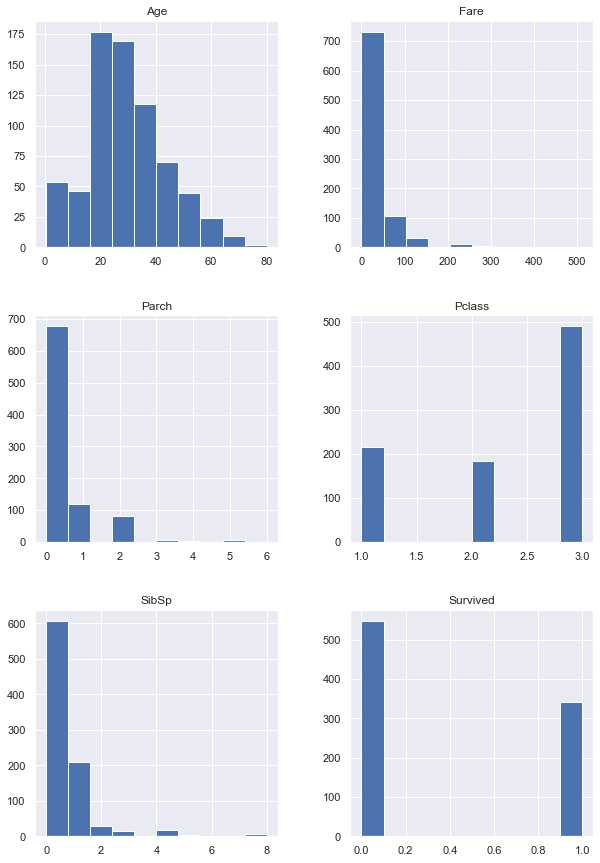

In [6]:
train.hist(column = ['Age', 'Fare', 'Parch', 'Pclass', 'SibSp', 'Survived'], figsize = (10, 15))

Text(0.5, 1.0, 'Embarked')

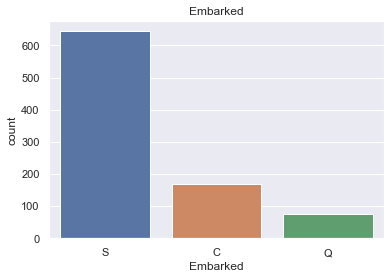

In [7]:
sns.countplot(x = 'Embarked', data = train)
plt.title('Embarked')

Text(0.5, 1.0, 'Survived by Sex')

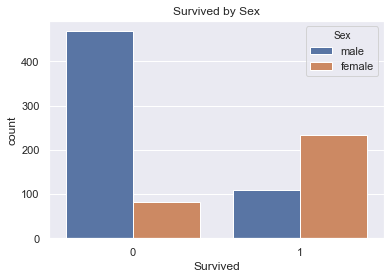

In [8]:
sns.countplot(x = 'Survived', hue = 'Sex', data = train)
plt.title('Survived by Sex')

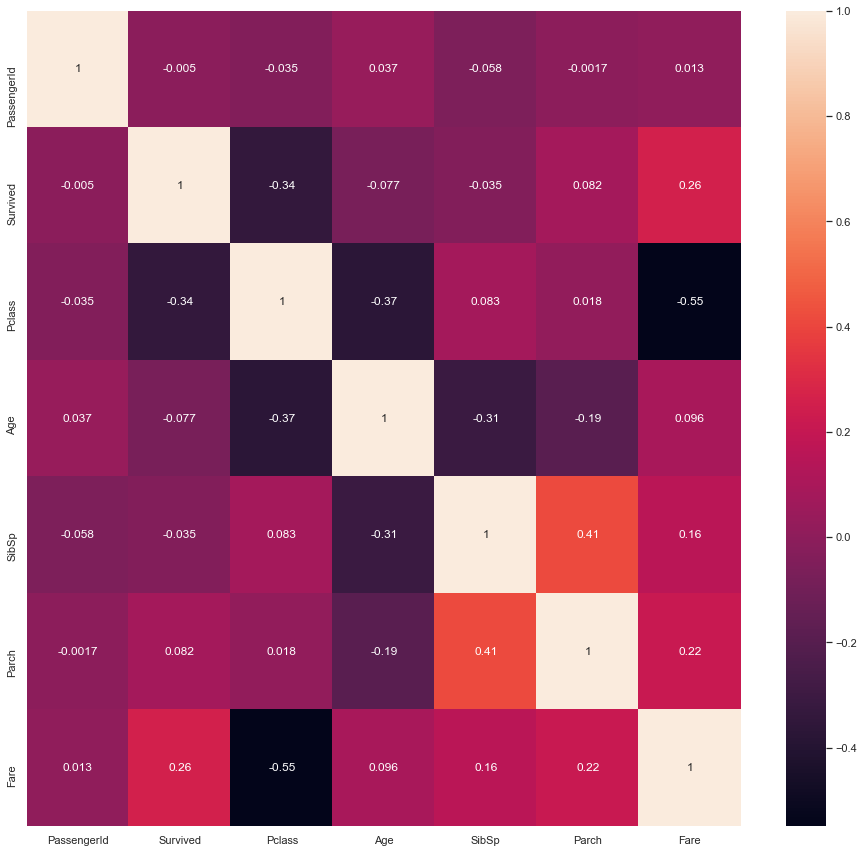

In [9]:
plt.figure(figsize = (16,15))
sns.heatmap(train.corr(), annot = True)

From the heatmap above, we see that pclass and fare are both strongly correlated with survival relative to the other features. Note that this is to be expected, particularly as pclass is a proxy for socioeconomic status, and the two variables are also highly correlated with one another.

As noted above, Age has a large number of missing variables. Due to the relevance of pclass on survival and the ease it provides via grouping, we will use pclass to impute missing age values.

### Training Set Missing Value Imputation

As noted above, Age has a large number of missing variables. Due to the relevance of pclass on survival and the ease it provides via grouping, we will use pclass to impute missing age values.

In [10]:
#Saving indices of missing values to check imputation below
traininds = [i for i, val in enumerate(train.Age.isnull()) if val]

In [11]:
train.loc[train.Age.isnull(),'Age'] = train.groupby('Pclass').Age.transform('mean')[train.Age.isnull()]

We also note that there are two misisng values in Embarked. Since this is a very small number of missing values, we will proceed by dropping the rows containing these missing values

In [12]:
train.dropna(subset = ['Embarked'], axis = 0, inplace = True)

Check to make sure the imputation was successful,

In [13]:
train.loc[traininds,['Age','Pclass']]

,Age,Pclass
5,25.14062,3
17,29.87763,2
19,25.14062,3
26,25.14062,3
28,25.14062,3
...,...,...
859,25.14062,3
863,25.14062,3
868,25.14062,3
878,25.14062,3


In [14]:
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

### Test Set Missing Value Imputation

When imputing missing values in the test data set, we will be using the values from the training set. This is to avoid a data leakage issue that may create issues in analysis.

We begin by imputing Age via the the means found in the test set based on Pclass.

In [15]:
#Finding means of Age in training set by Pclass
pgroups = train.groupby('Pclass')
pgroups.Age.describe()['mean']

Pclass
1    38.123473
2    29.877630
3    25.140620
Name: mean, dtype: float64

In [16]:
#Saving indices of missing values to check imputation below
testinds = [i for i, val in enumerate(test.Age.isnull()) if val]

test.loc[test.Age.isnull() * test['Pclass'] == 1,['Age']] = pgroups.Age.describe()['mean'][1]
test.loc[test.Age.isnull() * test['Pclass'] == 2,['Age']] = pgroups.Age.describe()['mean'][2]
test.loc[test.Age.isnull() * test['Pclass'] == 3,['Age']] = pgroups.Age.describe()['mean'][3]

There is also a missing value for Fare. We will deal with this value similar to how we dealt with the missing Age values. Noticing that the missing value belongs to Pclass 3, we will use the mean Fare from pgroups to impute.

In [17]:
test.loc[test.Fare.isna()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


In [21]:
test.loc[test.Fare.isna(), ['Fare']] = pgroups.Fare.describe()['mean'][3]

Check to make sure the imputation was successful.

In [22]:
test.loc[testinds,['Age','Pclass']]

,Age,Pclass
10,25.140620,3
22,38.123473,1
29,25.140620,3
33,25.140620,3
36,25.140620,3
...,...,...
408,25.140620,3
410,25.140620,3
413,25.140620,3
416,25.140620,3


In [24]:
test.loc[[152],['Fare','Pclass']]

,Fare,Pclass
152,13.67555,3


In [25]:
test.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64

There still remains multiple missing values in Cabin for both the training and test set. We will deal with those below.

### Categorical Variable Transformation and Feature Engineering

Here, we will first combine the test and training sets to recode the categorical variables that are currently strings into numberical representations for both the training and test sets. At the end, we will reseparate the two sets.

In [37]:
#Add column to test set to combine and identify test set entries.
test['Survived'] = np.nan

comp = pd.concat([train,test])

In [38]:
comp.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin          1014
Embarked          0
dtype: int64

In [39]:
comp.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [41]:
#Replacing Sex Values
comp.loc[comp.loc[:,'Sex'] == 'male', 'Sex'] = 0
comp.loc[comp.loc[:,'Sex'] == 'female', 'Sex'] = 1

#Replacing Embarked Values
comp.loc[comp.loc[:,'Embarked'] == 'S', 'Embarked'] = 0
comp.loc[comp.loc[:,'Embarked'] == 'C', 'Embarked'] = 1
comp.loc[comp.loc[:,'Embarked'] == 'Q', 'Embarked'] = 2

In [42]:
comp.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,1
2,3,1.0,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,0
4,5,0.0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,0


Also notice that, currently, the Name and Cabin columns are not numerically coded. By engineering these features, we can attempt to gather more information that could be useful in our model. 

Beginning with the Name column, we will first take the titles of all the names (e.g. Mr., Mrs., Miss, etc.) and replace them in the Name column. Then, we will consolidate these titles to a few of the most prominent titles based on similarity and finally code these titles numerically. 

In [49]:
comp['Name'] = comp.Name.str.extract(' ([A-Za-z]+)\.', expand = False)
comp.rename(columns = {'Name' : 'Title'}, inplace = True)
comp.Title.unique()

AttributeError: 'DataFrame' object has no attribute 'Name'

In [50]:
def replace_titles(x):
    title=x['Title']
    if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col', 'Sir']:
        return 'Mr'
    elif title in ['Countess', 'Mme', 'Lady','Dona']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title =='Dr':
        if x['Sex']=='Male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title

comp['Title'] = comp.apply(replace_titles, axis = 1)

In [52]:
title_dict = {'Mr' : 1, 'Miss' : 2, 'Mrs' : 3, 'Master' : 4}
comp['Title'] = comp['Title'].map(title_dict)

To deal with the Cabin column, we will first mark all missing values with "U" to signify unknown. We will then take the first character of each string in this column to represent the deck a particular cabin is on. Note that a few passengers have multiple cabins, but these are all on the same deck except for one. While this simplficiation is imperfect, the issues it causes will be minimal in the larger scheme.  

In [54]:
comp['Cabin'] = comp['Cabin'].fillna('U')
comp['Cabin'] = comp['Cabin'].map(lambda x: x[0])

In [56]:
cabin_dict = {'A':1, 'B':2, 'C':3, 'D':4, 'E':5, 'F':6, 'G':7, 'T':8, 'U':9}

comp['Cabin'] = comp['Cabin'].map(cabin_dict)

In [57]:
comp.Cabin.unique()

array([9, 3, 5, 7, 4, 1, 2, 6, 8], dtype=int64)

Lastly, we will create one new variable. Adding SibSp (the number of siblings/spouses aboard) and Parch (number of parents/children), we can create a new FamSize (family size) variable for each passenger.

In [58]:
comp['FamSize'] = comp['SibSp'] + comp['Parch']

In [62]:
comp.loc[comp.Survived.notna(),:]

,PassengerId,Survived,Pclass,Title,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamSize
0,1,0.0,3,1,0,22.00000,1,0,A/5 21171,7.2500,9,0,1
1,2,1.0,1,3,1,38.00000,1,0,PC 17599,71.2833,3,1,1
2,3,1.0,3,2,1,26.00000,0,0,STON/O2. 3101282,7.9250,9,0,0
3,4,1.0,1,3,1,35.00000,1,0,113803,53.1000,3,0,1
4,5,0.0,3,1,0,35.00000,0,0,373450,8.0500,9,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0.0,2,1,0,27.00000,0,0,211536,13.0000,9,0,0
887,888,1.0,1,2,1,19.00000,0,0,112053,30.0000,2,0,0
888,889,0.0,3,2,1,25.14062,1,2,W./C. 6607,23.4500,9,0,3
889,890,1.0,1,1,0,26.00000,0,0,111369,30.0000,3,1,0


In [63]:
#Reseparating test and training sets
train = comp.loc[comp.Survived.notna(),:]
test = comp.loc[comp.Survived.isna(),:]

With these steps finished, we are ready to begin analysis.

## Machine Learning Analysis

We will proceed using a Random Forest method in the analysis below. Using GridSearchCV, we will find the best parameters and use those to refit our training model. Based on that, we will then make the predictions for the test set, producing our final result.

In [67]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train.drop(columns = ['Survived','PassengerId', 'Ticket']), 
                                                    train['Survived'], 
                                                    test_size = 0.2)

In [69]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

RandomForest = RandomForestClassifier(random_state = 42)
params = {
    'criterion' : ['gini','entropy'],
    'n_estimators' : [150, 300, 450],
    'max_features': ['auto', 'log2'],
}

RandForestCV = GridSearchCV(estimator = RandomForest, param_grid = params, cv = 5)
RandForestCV.fit(X_train, y_train)

RandForestCV.best_params_

{'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 150}

In [75]:
BestForest = RandomForestClassifier(criterion = 'gini', max_features = 'auto', n_estimators = 150)
BestForest.fit(X_train, y_train)

predictions = BestForest.predict(X_test)

In [76]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, predictions)

0.8033707865168539

In [94]:
test['Survived'] = BestForest.predict(test.drop(columns = ['Survived','PassengerId','Ticket']))
test = test.astype({'Survived' : np.int})

In [96]:
test.loc[:,['PassengerId','Survived']].to_csv('fu_submission.csv',index = False)

This submission received a score of 0.75837 on Kaggle.